In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

In [3]:
random.seed(2024)
np.random.seed(2024)

In [4]:
def preprocessing_steps(data):
    df = data.copy()
    df = df.drop(columns=['first_20_events', 'time_since_last_event', 'Unnamed: 1', 'downpayment_cleared', 'first_purchase',
                          'max_milestone', 'downpayment_received', 'account_activitation', 'customer_id'])
    
    df = df.dropna(axis=0)
    df_0, df_1 = df[df.order_ships == 0], df[df.order_ships == 1]
    df_0 = df_0.sample(n=len(df_1), random_state=2024)
    # df_1 = df_1.sample(n=(len(df_0)), replace=True)
    df_balanced = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

    # shuffle
    df_balanced = df_balanced.sample(frac=1)

    df_X = df_balanced.drop(columns='order_ships')
    target = df_balanced.order_ships
    ori_df = df.drop(columns='order_ships')
    ori_target = df.order_ships

    boolean_col = ['discover', 'one_more_journey', 'approved_credit', 'has_prospecting', 'has_pre_application']

    for col in boolean_col:
        df_X[col] = [1 if val == True else 0 for val in df_X[col]]
        ori_df[col] = [1 if val == True else 0 for val in ori_df[col]]


    return ori_df, ori_target, df_X, target


def scaler(col):
    return (col - np.min(col)) / (np.max(col) - np.min(col))

In [5]:
class Embedding(nn.Module):
    def __init__(self, embedding_dim, n_events=5):
        super().__init__()
        self.fc1 = nn.Linear(n_events, embedding_dim, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(embedding_dim, embedding_dim, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    

def vec_to_list(event_list):
    event_list = event_list.replace('[', '').replace(']', '').split()
    event_list = [int(float(x)) for x in event_list]
    return event_list


def preprocessing_steps_embedding(data):
    df = data.copy()
    df = df.drop(columns=['Unnamed: 1', 'downpayment_cleared', 'first_purchase',
                          'max_milestone', 'downpayment_received', 'account_activitation', 'customer_id'])
    df = df.astype({col: 'float' for col in df.columns[:-2]})
    
    df = df.dropna(axis=0)


    events = df['first_20_events'].apply(vec_to_list)
    events = torch.tensor(events.to_list()).float()
    events_emb = Embedding(5, 20)
    events = events_emb(events)
    event_pd = pd.DataFrame(events.detach().numpy(), columns=[f'event_id_{i}' for i in range(5)])

    time = df['time_since_last_event'].apply(vec_to_list)
    time = torch.tensor(time.to_list()).float()
    time_emb = Embedding(5, 20)
    time = time_emb(time)
    time_pd = pd.DataFrame(time.detach().numpy(), columns=[f'time_{i}' for i in range(5)])
    df = pd.concat([df, event_pd, time_pd], axis=1)
    df = df.drop(columns=['first_20_events', 'time_since_last_event'])


    df_0, df_1 = df[df.order_ships == 0], df[df.order_ships == 1]
    df_0 = df_0.sample(n=len(df_1), random_state=2024)
    # df_1 = df_1.sample(n=(len(df_0)), replace=True)
    df_balanced = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

    # shuffle
    df_balanced = df_balanced.sample(frac=1)

    df_X = df_balanced.drop(columns='order_ships')
    target = df_balanced.order_ships
    ori_df = df.drop(columns='order_ships')
    ori_target = df.order_ships

    boolean_col = ['discover', 'one_more_journey', 'approved_credit', 'has_prospecting', 'has_pre_application']

    for col in boolean_col:
        df_X[col] = [1 if val == True else 0 for val in df_X[col]]
        ori_df[col] = [1 if val == True else 0 for val in ori_df[col]]


    return ori_df, ori_target, df_X, target

In [6]:
# Read in preprocessed original dataset
data = pd.read_csv('export_n_20.csv')

# Preprocess
ori_data, ori_target, df, target = preprocessing_steps_embedding(data)

In [7]:
nan_index = df.index[df.isna().any(axis=1)].tolist()
nan_index2 = ori_data.index[ori_data.isna().any(axis=1)].tolist()

df = df.apply(scaler)
df = df.drop(nan_index)
target = target.drop(nan_index)
# df = np.array(df)
ori_df = ori_data.apply(scaler)
ori_df = ori_df.drop(nan_index2)
ori_target = ori_target.drop(nan_index2)
# ori_df = np.array(ori_df)

## Something

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=.2, random_state=2024)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [28]:
test = LGBMClassifier(n_estimators=200,
                      max_depth=10,
                      learning_rate=0.1,
                      objective='binary',
                      verbose=-1,
                      random_state=2024).fit(X_train, y_train.astype(int))
pred = test.predict(ori_df)
accuracy_score(ori_target, pred)

0.8113559185624829

In [29]:
f1_score(ori_target, pred)

0.5012821673152925

## Naive models

In [58]:
# train on balanced data, test on all data
# Benchmark
log_clf = LogisticRegression(random_state=2024).fit(df, target)
log_pred = log_clf.predict(ori_df)

In [206]:
# Kernel based
svc_clf = SVC(random_state=2024).fit(df, target)
svc_pred = svc_clf.predict(ori_data)
print(accuracy_score(ori_target, svc_pred))

In [31]:
# Tree based method
dt = DecisionTreeClassifier(max_depth=5, random_state=2024).fit(df, target)
dt_pred = dt.predict(ori_df)
print(accuracy_score(ori_target, dt_pred))
print(f1_score(ori_target, dt_pred))

0.6758553545924221
0.5208558798905868


In [32]:
# Ensemble methods
xgb_clf = XGBClassifier(n_estimators=200,
                        max_depth=10,
                        learning_rate=0.1,
                        tree_method='hist',
                        objective='binary:logistic').fit(df, target)
xgb_pred = xgb_clf.predict(ori_df)
print(accuracy_score(ori_target, xgb_pred))
print(f1_score(ori_target, xgb_pred))

0.8206665297282493
0.5256797007172302


In [33]:
ada_clf = AdaBoostClassifier(n_estimators=200,
                             learning_rate=0.1,
                             random_state=2024).fit(df, target)

ada_pred = ada_clf.predict(ori_df)
print(accuracy_score(ori_target, ada_pred))
print(f1_score(ori_target, ada_pred))

0.7038556572983973
0.529450667114559


In [34]:
gb_clf = GradientBoostingClassifier(n_estimators=200,
                                    learning_rate=0.1,
                                    max_depth=10,
                                    tol=1e-5,
                                    random_state=2024).fit(df, target)
gb_pred = gb_clf.predict(ori_df)
print(accuracy_score(ori_target, gb_pred))
print(f1_score(ori_target, gb_pred))

0.802714383699043
0.5944392931267154


In [35]:
lgbm_clf = LGBMClassifier(n_estimators=200,
                          max_depth=10,
                          learning_rate=0.1,
                          objective='binary',
                          verbose=-1,
                          random_state=2024).fit(df, target)
lgbm_pred = lgbm_clf.predict(ori_df)
print(accuracy_score(ori_target, lgbm_pred))
print(f1_score(ori_target, lgbm_pred))

0.8085901228962235
0.5013284597065184


In [36]:
# Naive bayes
nb_clf = GaussianNB().fit(df, target)
nb_pred = nb_clf.predict(ori_df)
print(accuracy_score(ori_target, nb_pred))
print(f1_score(ori_target, nb_pred))

0.7748534218387947
0.35753471847315843


In [37]:
# sklearn nn
nn_clf = MLPClassifier(hidden_layer_sizes=(50, 25, 2), 
                       solver='adam', 
                       activation='relu',
                       learning_rate_init=0.01,
                       max_iter=400,
                       batch_size=32,
                       random_state=2024).fit(df, target)
nn_pred = nn_clf.predict(ori_df)
print(accuracy_score(ori_target, nn_pred))
print(f1_score(ori_target, nn_pred))

0.6831773556711124
0.5266220363623311


In [38]:
accuracy_res, f1_res = [], []
prediction_list = [log_pred, dt_pred, xgb_pred, ada_pred, gb_pred, lgbm_pred, nb_pred, nn_pred]

for pred in prediction_list:
    accuracy_res.append(accuracy_score(ori_target, pred))
    f1_res.append(f1_score(ori_target, pred))

In [39]:
print(accuracy_res)

[0.7168726148390794, 0.6758553545924221, 0.8206665297282493, 0.7038556572983973, 0.802714383699043, 0.8085901228962235, 0.7748534218387947, 0.6831773556711124]


In [40]:
print(f1_res)

[0.49025828678202305, 0.5208558798905868, 0.5256797007172302, 0.529450667114559, 0.5944392931267154, 0.5013284597065184, 0.35753471847315843, 0.5266220363623311]


In [18]:
print(accuracy_res)

[0.7079995674610565, 0.675852311980728, 0.8170282171585795, 0.703853801837089, 0.7750358947248271, 0.803010350897218, 0.7747439309379487, 0.807431259349149]


In [19]:
print(f1_res)

[0.48382920926399675, 0.5208535910694576, 0.5335052849071139, 0.529451181330849, 0.5562090767416642, 0.4900540105097329, 0.35769945612607595, 0.0]


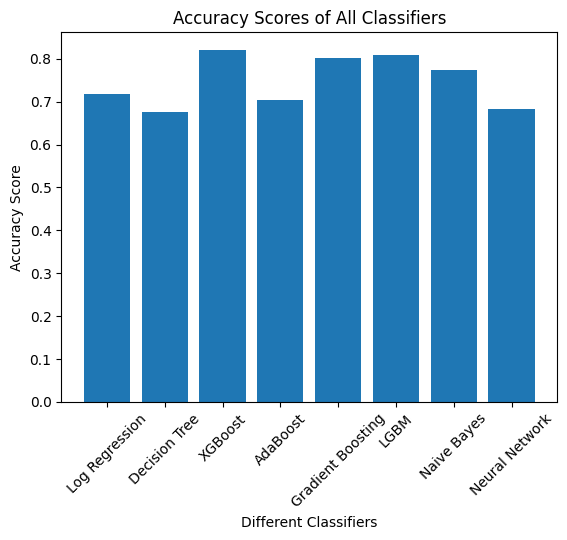

In [41]:
classifiers = ['Log Regression', 'Decision Tree', 'XGBoost', 'AdaBoost', 'Gradient Boosting', 'LGBM', 'Naive Bayes', 'Neural Network']
plt.bar(classifiers, accuracy_res)
plt.xticks(rotation=45)
plt.xlabel('Different Classifiers')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores of All Classifiers')
plt.show()

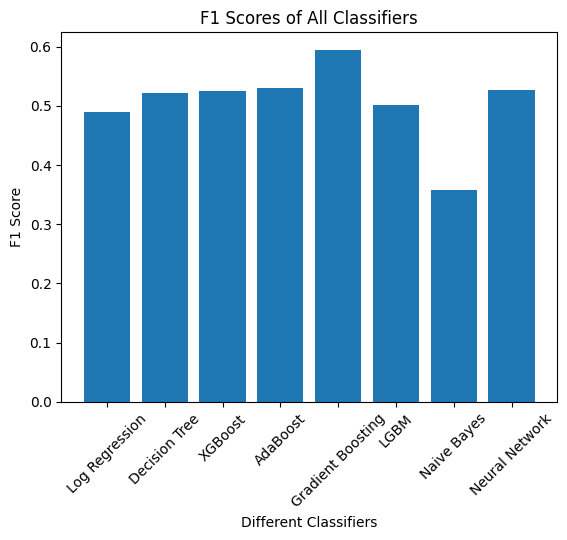

In [42]:
classifiers = ['Log Regression', 'Decision Tree', 'XGBoost', 'AdaBoost', 'Gradient Boosting', 'LGBM', 'Naive Bayes', 'Neural Network']
plt.bar(classifiers, f1_res)
plt.xticks(rotation=45)
plt.xlabel('Different Classifiers')
plt.ylabel('F1 Score')
plt.title('F1 Scores of All Classifiers')
plt.show()

In [54]:
prediction_list

[array([ True,  True, False, ..., False, False, False]),
 array([ True,  True,  True, ..., False, False,  True])]

## Later

In [ ]:
def cross_val(clf, ori_data, ori_target):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
    scores = cross_val_score(estimator=clf, X=ori_data, y=ori_target, cv=cv, scoring='f1')
    return scores.mean(), scores.std()

cross_val_mean, cross_val_std = [], []

cv_mean, cv_std = cross_val(log_clf, ori_data, ori_target)
cross_val_mean.append(cv_mean)
cross_val_std.append(cv_std)

In [65]:
f1_res

[0.4902600878241095]

## Dimension Reduction

In [8]:
from sklearn.decomposition import PCA 

# 6 components allow for around 71.50681% variance explained

pca = PCA(n_components=6, random_state=2024)
ori_df_reduced = pca.fit_transform(np.array(ori_df))
sum(pca.explained_variance_)

0.7323922262220652

## Smote

In [9]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report

In [10]:
sm = SMOTE(random_state=2024)
ori_reduced_new, ori_target_new = sm.fit_resample(ori_df_reduced, ori_target)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(ori_reduced_new, ori_target_new, test_size=.2, random_state=2024)

## Hyper parameter tuning

In [15]:
ori_df_reduced.shape

(1664590, 6)

In [16]:
import optuna 

def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
    }

    if param['booster'] in ['gbtree', 'dart']:
        param['max_depth'] = trial.suggest_int('max_depth', 1, 9)
        param['eta'] = trial.suggest_float('eta', 1e-8, 1.0, log=True)
        param['gamma'] = trial.suggest_float('gamma', 1e-8, 1.0, log=True)
        param['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    if param['booster'] == 'dart':
        param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        param['rate_drop'] = trial.suggest_float('rate_drop', 1e-8, 1.0, log=True)
        param['skip_drop'] = trial.suggest_float('skip_drop', 1e-8, 1.0, log=True)

    clf = XGBClassifier(**param)
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)

    preds = clf.predict(ori_df_reduced)
    f1 = f1_score(ori_target, preds)
    return f1


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-03-16 19:04:20,921] A new study created in memory with name: no-name-cc4da356-a3c6-4c26-b05b-b33981a10ff7
[I 2024-03-16 19:04:50,575] Trial 0 finished with value: 0.4193352200644091 and parameters: {'booster': 'gbtree', 'lambda': 0.0012315501433248597, 'alpha': 0.000348933245845045, 'max_depth': 3, 'eta': 0.00036936998926738126, 'gamma': 0.13115013421410948, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.4193352200644091.
[I 2024-03-16 19:06:10,723] Trial 1 finished with value: 0.4544287224255182 and parameters: {'booster': 'gbtree', 'lambda': 1.6829173449625458e-06, 'alpha': 1.0452501758442045e-07, 'max_depth': 8, 'eta': 3.236073528309192e-08, 'gamma': 2.355998859329853e-07, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.4544287224255182.
[I 2024-03-16 19:06:59,245] Trial 2 finished with value: 0.3809149884294586 and parameters: {'booster': 'dart', 'lambda': 1.7070390682205456e-05, 'alpha': 6.300264884071532e-07, 'max_depth': 1, 'eta': 3.413990815241385

KeyboardInterrupt: 

In [115]:
clf = XGBClassifier(n_estimators=300,
                        max_depth=10,
                        learning_rate=0.15,
                        tree_method='hist',
                        objective='binary:logistic').fit(X_train, y_train)
pred = clf.predict(ori_df_reduced)
print(accuracy_score(ori_target, pred))
print(f1_score(ori_target, pred))

0.7275010663286455
0.5468545985468546


In [116]:
print(classification_report(ori_target, pred))

              precision    recall  f1-score   support

         0.0       0.95      0.70      0.81   1344042
         1.0       0.40      0.85      0.55    320548

    accuracy                           0.73   1664590
   macro avg       0.68      0.78      0.68   1664590
weighted avg       0.85      0.73      0.76   1664590



In [117]:
print(confusion_matrix(ori_target, pred))

[[937290 406752]
 [ 46847 273701]]


In [118]:
def cross_val(clf, ori_data, ori_target):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
    scores = cross_val_score(estimator=clf, X=ori_data, y=ori_target, cv=cv, scoring='f1')
    return scores.mean(), scores.std()

cross_val_mean, cross_val_std = [], []

cv_mean, cv_std = cross_val(clf, ori_df_reduced, ori_target)
cross_val_mean.append(cv_mean)
cross_val_std.append(cv_std)

print(cv_mean)
print(cv_std)

0.33773828144541396
0.0017469392730006942


## CTGAN

In [44]:
ori_reduced

,0,1,2,3,4,5,order_ships
0,0.035000,0.720775,-0.016941,-0.331843,0.978013,-0.108952,1.0
1,0.088248,0.715691,0.050129,-0.285914,-0.050441,0.099609,0.0
2,-0.561659,-0.010016,-0.160623,-0.220332,-0.091934,0.057130,0.0
3,-0.561656,-0.010058,-0.160685,-0.220100,-0.091833,-0.127968,0.0
4,0.151613,-0.584930,-0.190111,0.459869,-0.024480,-0.006625,0.0
...,...,...,...,...,...,...,...
1664585,0.826646,0.057099,0.070819,-0.150981,-0.001520,-0.124125,0.0
1664586,-0.589935,0.084985,-0.217389,0.397853,-0.069141,-0.131159,0.0
1664587,-0.561651,-0.009910,-0.160514,-0.220723,-0.091587,0.162520,0.0
1664588,-0.726434,-0.139215,0.810271,-0.121596,-0.031717,-0.128345,0.0


In [ ]:
from ctgan import CTGAN
ori_reduced = pd.concat([pd.DataFrame(ori_df_reduced), ori_target], axis=1).dropna()
label1 = ori_reduced[ori_reduced.order_ships == 1]
label1.order_ships = [True if x == 1.0 else False for x in label1.order_ships]
label1.columns = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'order_ships']
label1 = label1.iloc[:1000, :]

ctgan = CTGAN(epochs=10, cuda=True, verbose=True)
ctgan.fit(label1)

label1_samp = ctgan.sample(400000)

In [45]:
label1_samp = pd.read_csv('label1_samp.csv')

In [66]:
ori_reduced.columns = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'order_ships']

In [74]:
label0_train = ori_reduced[ori_reduced.order_ships == 0].sample(720000, random_state=2024)
label1_train = pd.concat([
    ori_reduced[ori_reduced.order_ships == 1],
    label1_samp.drop(columns='Unnamed: 0')
], axis=0)
new_data = pd.concat([label0_train, label1_train], axis=0)
train_data = new_data.drop(columns='order_ships')
train_target = new_data.order_ships

In [77]:
ori_df_reduced.shape

(1664590, 6)

In [86]:
clf = LGBMClassifier(n_estimators=200,
                          max_depth=4,
                          learning_rate=0.1,
                          objective='binary',
                          verbose=-1,
                          random_state=2024).fit(train_data, train_target)
pred = clf.predict(ori_reduced.drop(columns='order_ships'))
print(accuracy_score(ori_reduced.order_ships, pred))
print(f1_score(ori_reduced.order_ships, pred))

0.7846752609965881
0.06199070741443622


In [84]:
ori_df_reduced.shape

(1664590, 6)

In [87]:
def cross_val(clf, ori_data, ori_target):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
    scores = cross_val_score(estimator=clf, X=ori_data, y=ori_target, cv=cv, scoring='f1')
    return scores.mean(), scores.std()

cross_val_mean, cross_val_std = [], []

cv_mean, cv_std = cross_val(clf, ori_df_reduced, ori_target)
cross_val_mean.append(cv_mean)
cross_val_std.append(cv_std)

print(cv_mean)
print(cv_std)

0.29064289429033324
0.004161261324768215


## KNN

In [96]:
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(ori_reduced_new, ori_target_new, 
                                                    test_size=.2, random_state=2024)
knn = KNeighborsClassifier(n_neighbors=7).fit(X_train, y_train)
pred = knn.predict(X_test)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

0.7956668036911035
0.8118514103479755


In [98]:
pred2 = knn.predict(ori_reduced.drop(columns='order_ships'))
print(accuracy_score(ori_reduced.order_ships, pred2))
print(f1_score(ori_reduced.order_ships, pred2))

0.5824517274987712
0.25519974190201494


In [99]:
ori_reduced

,col1,col2,col3,col4,col5,col6,order_ships
0,0.035000,0.720775,-0.016941,-0.331843,0.978013,-0.108952,1.0
1,0.088248,0.715691,0.050129,-0.285914,-0.050441,0.099609,0.0
2,-0.561659,-0.010016,-0.160623,-0.220332,-0.091934,0.057130,0.0
3,-0.561656,-0.010058,-0.160685,-0.220100,-0.091833,-0.127968,0.0
4,0.151613,-0.584930,-0.190111,0.459869,-0.024480,-0.006625,0.0
...,...,...,...,...,...,...,...
1664585,0.826646,0.057099,0.070819,-0.150981,-0.001520,-0.124125,0.0
1664586,-0.589935,0.084985,-0.217389,0.397853,-0.069141,-0.131159,0.0
1664587,-0.561651,-0.009910,-0.160514,-0.220723,-0.091587,0.162520,0.0
1664588,-0.726434,-0.139215,0.810271,-0.121596,-0.031717,-0.128345,0.0


In [ ]:
def cross_val(clf, ori_data, ori_target):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
    scores = cross_val_score(estimator=clf, X=ori_data, y=ori_target, cv=cv, scoring='f1')
    return scores.mean(), scores.std()

cross_val_mean, cross_val_std = [], []

cv_mean, cv_std = cross_val(clf, ori_df_reduced, ori_target)
cross_val_mean.append(cv_mean)
cross_val_std.append(cv_std)

print(cv_mean)
print(cv_std)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(ori_reduced.drop(columns='order_ships'), ori_reduced.order_ships, test_size=.2, random_state=2024)
scale = sum(y_train == 0) / sum(y_train == 1)
clf = XGBClassifier(n_estimators=300,
                    max_depth=10,
                    learning_rate=0.15,
                    tree_method='hist',
                    scale_pos_weigght=scale,
                    num_class=1).fit(X_train, y_train)

cv_mean, cv_std = cross_val(clf, ori_reduced.drop(columns='order_ships'), ori_reduced.order_ships)
print(cv_mean)
print(cv_std)

[16:53:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weigght" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:53:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weigght" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:53:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weigght" } might not 